In [6]:
import numpy as np
from google.colab import drive
import os
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [7]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Define paths to your image folders
image_folder_car = '/content/drive/My Drive/Image Analysis/imageset3/car/'
image_folder_face = '/content/drive/My Drive/Image Analysis/imageset3/face/'

In [9]:
# Load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize images to a consistent size
            img = img.astype('float32') / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)




In [10]:
# Load images and labels
car_images, car_labels = load_images_from_folder(image_folder_car, 0)  # Label 0 for cars
face_images, face_labels = load_images_from_folder(image_folder_face, 1)  # Label 1 for faces

# Combine car and face images
images = np.concatenate((car_images, face_images), axis=0)


In [11]:
# Load pre-trained model
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

def extract_features(images):
    features = []
    for img in images:
        img = preprocess_input(img)  # Pre-process image for VGG16
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        feature = model.predict(img)
        features.append(feature.flatten())
    return np.array(features)

# Extract features using the pre-trained model
features = extract_features(images)

1/1 [==============================] - 1s 549ms/step


In [12]:
# Normalize and standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


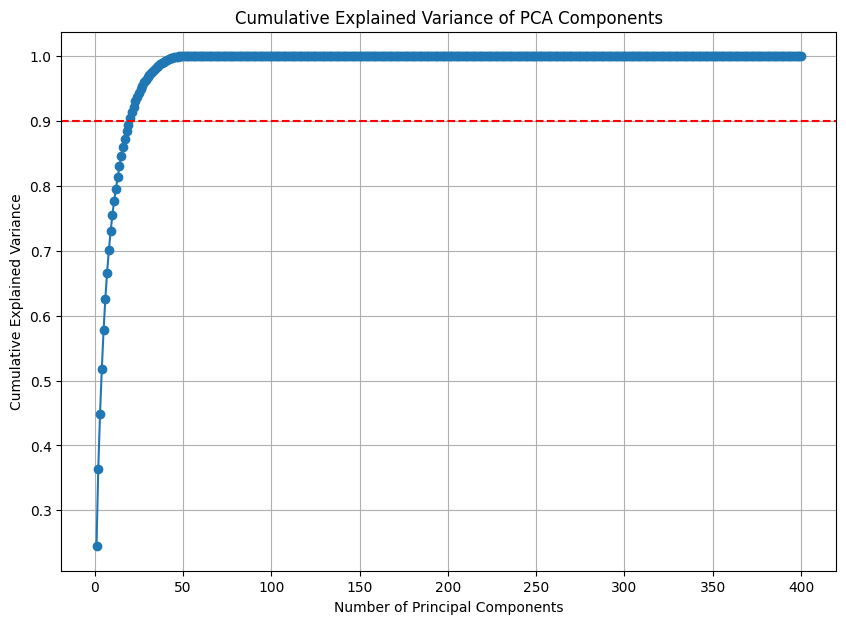

Number of PCA components explaining 90% variance: 20


In [13]:
# Apply PCA
pca = PCA()
features_pca = pca.fit_transform(features_scaled)

# Determine the number of PCA components needed to retain at least 90% of variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.90) + 1

# Plot cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title('Cumulative Explained Variance of PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print(f'Number of PCA components explaining 90% variance: {n_components}')


In [14]:
# Reduce dimensionality to the selected number of components
pca = PCA(n_components=n_components)
features_pca_optimal = pca.fit_transform(features_scaled)


In [15]:
# Apply Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2)  # Set number of clusters to 2 for car and face
agg_labels = agg_clustering.fit_predict(features_pca_optimal)


In [16]:
# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(features_pca_optimal, agg_labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.46955299377441406


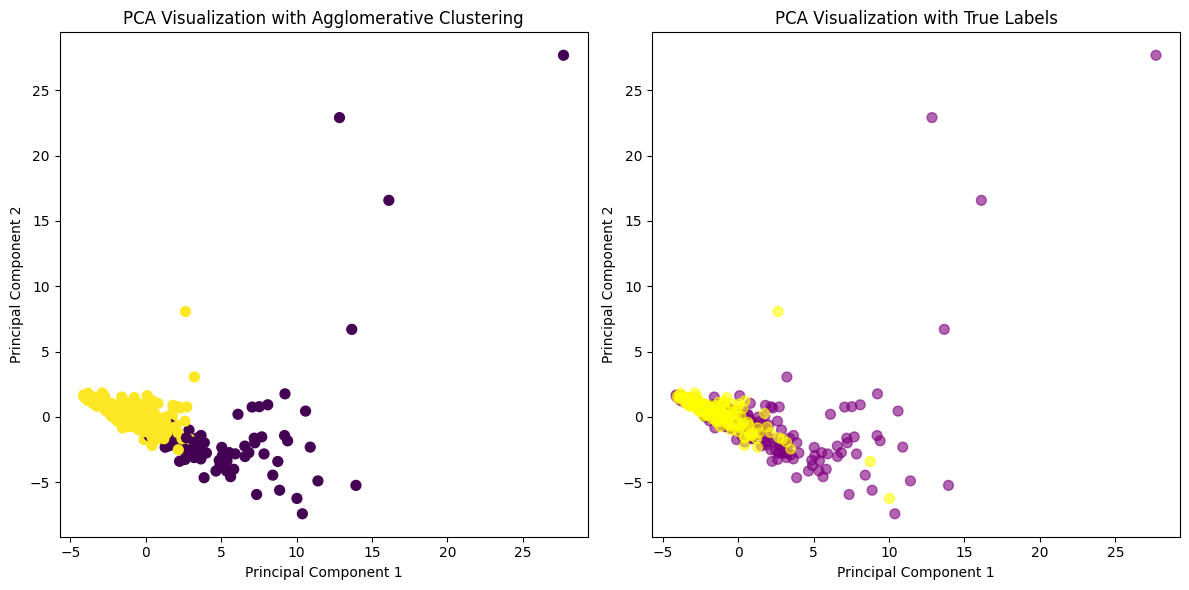

In [17]:
# Plot Agglomerative Hierarchical Clustering results
plt.figure(figsize=(12, 6))

# PCA Visualization with Agglomerative Clustering
plt.subplot(1, 2, 1)
plt.scatter(features_pca_optimal[:, 0], features_pca_optimal[:, 1], c=agg_labels, cmap='viridis', s=50)
plt.title('PCA Visualization with Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# PCA Visualization with True Labels
plt.subplot(1, 2, 2)
true_labels = np.concatenate((car_labels, face_labels))

# Define colors for labels
colors = ['purple', 'yellow']  # Colors for classes
cmap = mcolors.ListedColormap(colors)

plt.scatter(features_pca_optimal[:, 0], features_pca_optimal[:, 1], c=true_labels, cmap=cmap, s=50, alpha=0.6)
plt.title('PCA Visualization with True Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()